# Simulate gamma ray sources in galaxy

In [1]:
#Imports
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import poisson, laplace, lognorm
from astropy.io import fits
from astropy.table import Table,join
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import catalog_spect
from scipy.optimize import curve_fit
import astropy.coordinates as coord
from astropy import units
import healpy as hp
import makemap

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10, 8)
#constants 
kpc = 3.08567758e21 #cm
n = 1000 #Number of spaces in grid (r,z,flux)
model = 'C' #Set model to S or C
if model=='C':
    H=0.18
    alp=1.9
    bet = 5.0
if model=='S':
    H=0.33
    alp=0.2
    bet = 1.4
Rsun = 8.3
hb = 10 #This is considered as high latitude

#Trheshold of fermi, from 3fgl/3fhl? paper
fermi_thres = 5e-9#min_3fgl_high_lat 
flux_logspace = np.logspace(-12,-6,n)

In [2]:
#Function definitions

def R_dep(R,alpha=alp, beta=bet):
    "R distribution of sources from lorimer"
    return ((R/Rsun)**alpha)*np.exp(-beta*(R-Rsun)/Rsun)

def rand_z(n,H=H):
    """Return random z from laplace distribution=exp(-abs(z))
    n = number of randoms"""
    return laplace.rvs(0,H,size=n)

def rand_L(u,a,Lmin,Lmax):
    if a==1:
        print "a==1, error"
        return 0
    return (u*(Lmax**(1-a)-Lmin**(1-a))+Lmin**(1-a))**(1/(1-a))

In [3]:
#Load 3fgl
file_3fgl = 'gll_psc_v16.fit'
file_3fhl ='gll_psch_v13.fit'
try:
    fgl=True
    data = fits.getdata(file_3fgl)
except:
    fgl = False
    print "3fgl data not available"
try:
    fhl=True
    data_fhl = fits.getdata(file_3fhl)
except:
    fhl=False
    print "3fhl data not available"
if fgl:
    tb = Table(data)
    cls = np.asarray(tb['CLASS1'].tolist())
    cls = np.char.lower(np.char.rstrip(cls, ' '))
    lat = tb['GLAT']
    lon = tb['GLON']
#Sources to use, use unassosciated sources at low b?
    gal_mask = (cls=='psr') | (cls =='pwn') | (cls=='snr') | (cls=='spp') | ((cls=='') & (np.abs(lat)<10))
    gal = tb[gal_mask]
    lat_gal = gal['GLAT'] #l,b of gal sources
    lon_gal = gal['GLON']
    lon_gal[lon_gal>180]-=360
    flux_3fgl = gal['Flux1000']
    #spectra
    #TODO 
    spec_3fgl = catalog_spect.get_spec(file_3fgl)[gal_mask]
    ave_spec_3fgl = np.average(spec_3fgl,axis=0)
    _E = np.logspace(-1,2,len(ave_spec_3fgl))#GeV
    fit_func = lambda E,a,b: a-b*np.log10(E)
    fit,cov = curve_fit(fit_func,_E,np.log10(ave_spec_3fgl),p0=[-12,2.2])
    pwl_3fgl = fit[1]
    print "Average powerlaw index of 3fgl sources:",pwl_3fgl
    high_lat_mask_3fgl = np.abs(lat_gal)>=hb


if fhl:
    tb_fhl= Table(data_fhl)
    cls_fhl = np.asarray(tb_fhl['CLASS'].tolist())
    cls_fhl = np.char.lower(np.char.rstrip(cls_fhl, ' '))
    lat_fhl = tb_fhl['GLAT']
    lon_fhl = tb_fhl['GLON']
#Sources to use, use unassosciated sources at low b?
    gal_mask_fhl = (cls_fhl=='psr') | (cls_fhl =='pwn') | (cls_fhl=='snr') | (cls_fhl=='spp') | ((cls_fhl=='') & (np.abs(lat_fhl)<10))
    gal_fhl = tb_fhl[gal_mask_fhl]
    lat_gal_fhl = gal_fhl['GLAT'] #l,b of gal sources
    lon_gal_fhl = gal_fhl['GLON']
    lon_gal_fhl[lon_gal_fhl>180]-=360
    #spectra
    #TODO 
    spec_3fhl = catalog_spect.get_spec(file_3fhl)[gal_mask_fhl]

    fit_func = lambda E,a,b: a-b*np.log10(E)
    ave_spec_3fhl = np.average(spec_3fhl,axis=0)
    _E = np.logspace(1,3,len(ave_spec_3fhl))#GeV
    #plt.loglog(_E,ave_spec_3fhl)
    fit,cov = curve_fit(fit_func,_E,np.log10(ave_spec_3fhl),p0=[-12,2.2])
    pwl_3fhl = fit[1]
    print "Average powerlaw index of 3fhl sources:",pwl_3fhl


#log n log s

#    N_3fgl = np.zeros(n)

#Create log n log s plot, deprecated??
  #  for i,f in enumerate(flux_logspace):
  #      N_3fgl[i] = len(spec_3fgl[flux_3fgl > f])



Average powerlaw index of 3fgl sources: 2.442718948
Average powerlaw index of 3fhl sources: 2.22967460056


In [8]:

#Do the simulation monte carlo
def mc_smpl(a=2,N=1000,Lmin=3e34,Lmax=1e40):
    np.random.seed(0)
    """Sample from above distribution N times: r,z,L and calculate flux as measured at earth"""
    N = int(N) #no samples just to be sure
    #set up R, has to be looped over, no analytical inverse 
    r = np.linspace(0.,50,n) 

    x0,y0,z0 = Rsun,0,0 #Location of us
    
    #set up pdf/cdf of desired distributions
    data_R = R_dep(r)
    data_R = data_R/np.sum(data_R)#normalize
    data_R_cdf = np.cumsum(data_R)#cdf
    #setup arrays for samples
    R_smpl = np.zeros(N)
    u = np.random.rand(N) #For R
    u2 = np.random.rand(N)# For L
    phi_smpl = np.random.rand(N)*2*np.pi #uniform distribution for phi
    L_smpl = rand_L(u2,a,Lmin,Lmax)#random L
    z_smpl = rand_z(N)
    for i in range(N):
        #Inverse transform sampling, numerical
        xx= np.argmax(u[i]<=data_R_cdf)
        R_smpl[i]=r[xx]
        
    #plot test
#    hist,bins = np.histogram(L_smpl, bins=np.logspace(35,39,50),density=True)
#    bins = (bins[0:-1]+bins[1:])/2.
#    plt.loglog(bins,hist,'bo')
#    plt.loglog(L,LF(L,Lmin))
#    plt.show()
    
    #distances from source to earth, calc flux
    x,y,z = R_smpl*np.cos(phi_smpl),R_smpl*np.sin(phi_smpl),z_smpl
    dist = np.sqrt(((x-x0))**2+((y-y0))**2+(z-z0)**2)
    distkpc = (dist*kpc)
    flux_data = L_smpl/(4*np.pi*distkpc**2)
    
    #skymap astropy
    c = coord.Galactocentric(x=x*units.kpc,y=y*units.kpc,z=z*units.kpc)
    c_gal = c.transform_to(coord.Galactic)

    l = c_gal.l.degree
    b = c_gal.b.degree
    l[l>180]-=360.
    #Make skymap, l,b. 
   # b = np.arcsin(z/dist)
    #l = np.arctan2(y0-y,x0-x)
    #l = l*180/np.pi
    #b = b*180/np.pi
    #npix = 
    #nside = 512
    #npix = hp.nside2npix(nside)
    #pix = hp.ang2pix(nside,l,b,lonlat=True)
    #hp_map = np.zeros(npix)
    
   # np.add.at(hp_map,pix,flux_data) #To make sure recurring pixels are added on top of each other
#,lonra=[-180,180],latra=[-90,90]
   # mp = hp.cartview(hp_map, xsize=720,ysize=360,min=0,max=1e20,return_projected_map=True);
   # plt.close()
    
    high_lat_mask = np.abs(b)>hb
    flux_hb = flux_data[high_lat_mask]

    mp = makemap.makemap(l,b,flux_data,0.5)
    #plt.imshow(map_)
    #Test plot l,b

   # f = plt.figure()
  #  ax = f.add_subplot(111)

    #h =ax.hist2d(l,b,bins=100,weights=np.log10(flux_data),cmin=-13,cmax=-1)
   # f.colorbar(h[3],ax=ax)
   # ax.scatter(l,b,marker='.',s=4,label='simulation')
   # if fgl:
  #      ax.scatter(lon_gal,lat_gal, marker='.',label='3fgl gal')
    
   # masklb = ((np.abs(l)>80)&(np.abs(l)<100))
   # ax.scatter(x[masklb],z[masklb], s=10,marker='.',alpha=0.8)
   # ax.scatter(x[~masklb],z[~masklb], s=10,marker='.',alpha=0.8)
    #ax.scatter(x,y,z, marker='.')
    #ax.scatter(x0,y0,z0,marker='o',c='red')
    #setup logn-logs for simulated sources
    #Ns = np.zeros(n)
    #for i,f in enumerate(flux_logspace):
    #    Ns[i]= len(flux_data[flux_data > f])
        
    #Print some info
    prnt = False
    #detected = flux_data[flux_data >= fermi_thres]
    #undetected = flux_data[flux_data < fermi_thres]
    #flux_undet = np.sum(undetected)
    #flux_det = np.sum(detected)
    #if prnt:
    #    print "flux in undetected:", flux_undet
    #    print "total flux simulation ", np.sum(flux_data)
    #    if fgl:
    #        print "total flux 3fgl:", np.sum(flux_3fgl)    
        #print "sources 3fgl high lat", len(flux_3fgl_high_lat)
    #print "sources simulation high lat", N_high_lat

    
    #Set up histogram of flux
    #mc_hist,mc_bins = np.histogram(flux_data,bins=np.logspace(-13,-5,25))
    #mc_hist_hb,mc_bins_hb = np.histogram(flux_data[high_lat_mask],bins=np.logspace(-13,-5,25))
   # mc_bins= (mc_bins[1:]+mc_bins[0:-1])/2.
    return flux_data,mp

8.80285972668e-06 8.80285972668e-06


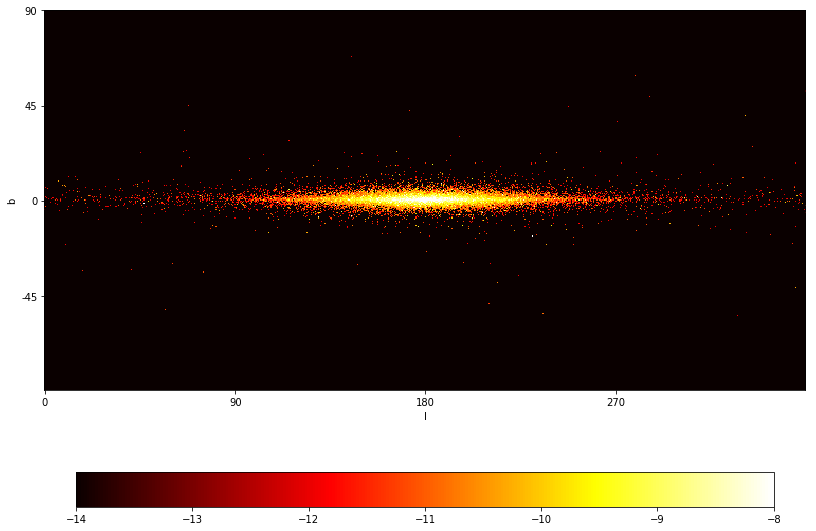

In [10]:
##Flux for l,b. Works but is total flux from healpy lower than total flux in sim...??? That is weird
test,mp = mc_smpl(1.8,40000,3e34,1e39)
print np.sum(test),np.sum(mp)
mp[mp==0]=1e-14
mp = np.log10(mp)
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(111)
ax.set_xticks([0,180,360,540,720])
ax.set_xticklabels([0,90,180,270,360])
ax.set_yticks([0,90,180,270,360])
ax.set_yticklabels([90,45, 0,-45,-90])
ax.set_xlabel('l')
ax.set_ylabel('b')
im = ax.imshow(mp[:,:],cmap='hot',vmin=-14,vmax=-8)
fig.colorbar(im,orientation='horizontal',shrink=0.5)

In [142]:
#Runs simulation Nsmpl times with N=n.o. sources

N =50000
#N2 = 150000
Nsmpl = 100
fluxes = np.zeros((Nsmpl,N))
#fluxes2 = np.zeros((Nsmpl,N2))
fluxes_check = np.zeros(N)
for i in range(Nsmpl):
    if i%(Nsmpl/10)==0:
        print 100*i/float(Nsmpl),"% done"
      #  print np.sum(fluxes_check)/i
    fluxes[i,:]=np.sort(mc_smpl(1.9,N,3e34,1e39)[0])
   # fluxes2[i,:] = np.sort(mc_smpl(2,N2,3e34,1e39))
   # fluxes_check += mc_smpl(1.8,N,3e34,1e39)[0]
    
#Take average flux from sorted flux distribution
ave_flux = np.average(fluxes,axis=0)
#ave_flux2 = np.average(fluxes2,axis=0)
#ave_flux = fluxes/Nsmpl
print "100% done"

0.0 % done
10.0 % done
20.0 % done
30.0 % done
40.0 % done
50.0 % done
60.0 % done
70.0 % done
80.0 % done
90.0 % done
100% done


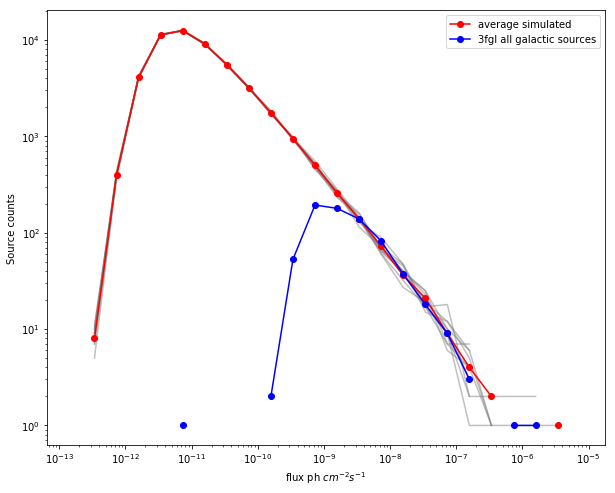

In [134]:
#Plot histogram of N vs flux for simulations and 3fgl and compare

flux_detected = ave_flux[ave_flux>=fermi_thres]
flux_undetected = ave_flux[ave_flux<fermi_thres]
total_flux_det = np.sum(flux_detected)
total_flux_undet = np.sum(flux_undetected)
f2,ax2 = plt.subplots(1)
minflux = np.log10(min(ave_flux))
maxflux = np.log10(max(ave_flux))
minflux,maxflux=-13,-5
bins = np.logspace(minflux,maxflux,25)
bins_mean = (bins[1:]+bins[:-1])/2.
for i,flux in enumerate(fluxes):
    mc_hist,mc_bins = np.histogram(flux,bins=bins)
    ax2.loglog(bins_mean,mc_hist,alpha=0.5,color='grey')

mc_hist,mc_bins = np.histogram(ave_flux,bins=bins)
ax2.loglog(bins_mean,mc_hist,marker='o',label='average simulated', color='red')

if fgl:
   # hist_3fgl_hb, bins_3fgl = np.histogram(flux_3fgl[high_lat_mask_3fgl], bins=bins)
   # ax2.loglog(bins_mean,hist_3fgl_hb, marker='+',label='3fgl high lat')
    hist_3fgl, bins_3fgl = np.histogram(flux_3fgl, bins=bins)
    ax2.loglog(bins_mean,hist_3fgl, marker='o',color='blue',label='3fgl all galactic sources')

#mc_hist2,mc_bins2 = np.histogram(ave_flux2,bins=np.logspace(minflux,maxflux,20))
#plt.loglog(mc_bins,mc_hist2,marker='v', label='L_index=2. N=150000')

ax2.set_xlabel(r'flux ph $cm^{-2} s^{-1}$')
ax2.set_ylabel('Source counts')
ax2.legend()
#Remove maximum values
flux_3fgl[np.argmax(flux_3fgl)]=0
ave_flux[np.argmax(ave_flux)]=0
#f2.savefig('n_flux_allsky.pdf')

In [55]:
#Get total diffuse spectra
import open_dat
try:
    datFile=open_dat.open_dat('r5_fulldisk_spectra.dat')
    diff = True
except Exception as e:
    diff = False
    print "No r5 file"
    print e
if diff:
    E_diff = datFile['emean']
    deltaE = datFile['delta_e']
    total_gas_spec = np.zeros_like(E_diff)
    mask_diff = E_diff > 1
    for d in datFile:
        if 'Gas' in d and not 'err' in d:
            total_gas_spec+=datFile[d]
    sr =0.25*np.radians(1)**2*(720*81)
    total_gas_spec =sr*(total_gas_spec/deltaE)[mask_diff]
    E_diff = E_diff[mask_diff]
    #plt.loglog(E_diff,E_diff**2*total_gas_spec)
    #plt.loglog(E_diff,E_diff**2*total_gas_spec[0]*E_diff**-2.5)

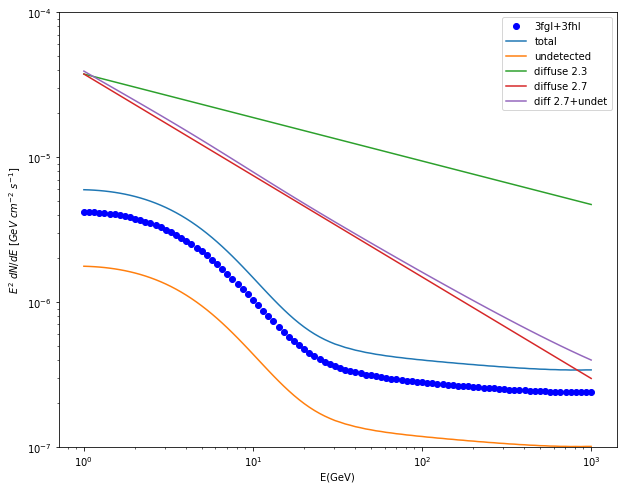

In [136]:
#Take the average spectra of 3fgl+3fhl and give that spectra to the simulated sources
#Plot the spectra from 1-1000GeV
Efhl = np.logspace(1,3,100)#GeV
E3fgl = np.logspace(-1,2,100)
E = np.logspace(0,3,100)
fhl_fgl = np.zeros_like(E)
mask_Efhl = Efhl>100
mask_E = E>30


if fgl and fhl:
    total_spec_3fgl = np.sum(spec_3fgl,axis=0)
    total_spec_3fhl = np.sum(spec_3fhl,axis=0)

    intp_3fgl = np.interp(E,E3fgl,total_spec_3fgl)
    intp_3fhl = np.interp(E,Efhl,total_spec_3fhl)
    intp_3fgl[mask_E]=intp_3fhl[mask_E]

    intp_3fgl_normed = intp_3fgl/np.max(intp_3fgl)
    intp_3fgl = np.sum(flux_3fgl)*intp_3fgl_normed
    spec_sim = np.sum(ave_flux)*intp_3fgl_normed
    #spec_sim_detected = total_flux_det*intp_3fgl_normed
    spec_sim_undet = spec_sim-intp_3fgl
    #spec_sim2 = np.sum(ave_flux2)*intp_3fgl_normed
    
    #plt.loglog(E,E**2*spec_sim2,'k--',label='2')
    plt.loglog(E,E**2*intp_3fgl,'bo',label='3fgl+3fhl')
    plt.loglog(E,E**2*spec_sim,label='total')
    #plt.loglog(E,E**2*spec_sim_detected,label='detected')
    plt.loglog(E,E**2*spec_sim_undet,label='undetected')
    if diff:
        diff_flux_1GeV = total_gas_spec[0]
        diffuse = diff_flux_1GeV*E**-2.7
        diffuse2 = diff_flux_1GeV*E**-2.3
        plt.loglog(E,E**2*diffuse2,label='diffuse 2.3')
        plt.loglog(E,E**2*diffuse,label='diffuse 2.7')
        plt.loglog(E,E**2*(diffuse+spec_sim_undet),label='diff 2.7+undet')
    plt.xlabel("E(GeV)")
    plt.ylabel(r"$E^2 \ dN/dE \ [GeV \ cm^{-2} \ s^{-1}]$")
    #plt.xlim([0.1,1e3])
    plt.ylim([1e-7,1e-4])
    plt.legend()

In [141]:
#Estimate contribution of flux from undetected sources

print "Percentage of flux in undetected and diffuse"
#Change from index 2.3->2.7 at 100GeV
def ratio(E,index1=2.5,index2=2.7):
    return E**-index1/E**-index2-1
test_E = [1,10,31,50,100,201,498,1000]

print "ratios"
for e in test_E:
    index_e = (np.round(E,0)==e)
    index_e = np.argmax(index_e)
    undet_flux = spec_sim_undet[index_e]
    diff_flux = diffuse[index_e]
    print "%% flux in undetected sources vs diffuse emission = %.1f %%"%(100*undet_flux/diff_flux)
    print "Need: at %.0f GeV: %.1f %%"%(e,ratio(e)*100)

Percentage of flux in undetected and diffuse
ratios
% flux in undetected sources vs diffuse emission = 4.7 %
Need: at 1 GeV: 0.0 %
% flux in undetected sources vs diffuse emission = 5.9 %
Need: at 10 GeV: 58.5 %
% flux in undetected sources vs diffuse emission = 4.5 %
Need: at 31 GeV: 98.7 %
% flux in undetected sources vs diffuse emission = 5.4 %
Need: at 50 GeV: 118.7 %
% flux in undetected sources vs diffuse emission = 7.9 %
Need: at 100 GeV: 151.2 %
% flux in undetected sources vs diffuse emission = 12.0 %
Need: at 201 GeV: 188.8 %
% flux in undetected sources vs diffuse emission = 21.1 %
Need: at 498 GeV: 246.3 %
% flux in undetected sources vs diffuse emission = 34.0 %
Need: at 1000 GeV: 298.1 %
